In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler 
import xgboost as xgb 
import matplotlib.pyplot as plt 
import seaborn as sns

In [52]:
x = pd.read_csv('X_features.csv')
y_reaction = pd.read_csv('y_reaction.csv')
y_severity = pd.read_csv('y_severity.csv')

In [53]:
y_reaction.shape,y_severity.shape,x.shape

((1260833, 1), (1260833, 1), (1260833, 12))

In [54]:
df_model = x.copy()
df_model['y_reaction'] = y_reaction.values
df_model['y_severity']= y_severity.values 

In [55]:
X_fea= df_model.drop(['y_reaction','y_severity'],axis = 1)
y_reaction_target = df_model['y_reaction'] 
y_severity_target = df_model['y_severity']-1

In [56]:
# Y_Reaction (Reaction Type Prediction)
# What it predicts: Which specific adverse reaction will occur (e.g., "Nausea", "Headache", "Rash")

# Intuition/Use Case:

# Early warning system: "If patient takes Drug X for Condition Y, they're likely to experience Reaction Z"
# Personalized medicine: Predict which specific side effects a patient might experience
# Drug development: Identify common reaction patterns for new drugs
# Clinical decision support: Help doctors anticipate and prepare for specific adverse events
# Example: Patient on METFORMIN for diabetes → Predict they'll likely experience "Gastrointestinal discomfort" rather than "Liver damage"

# Y_Severity (Severity Level Prediction)
# What it predicts: How serious the adverse event will be (1=Other, 3=Hospitalization, 6=Death)

# Intuition/Use Case:

# Risk stratification: Identify high-risk patients who need closer monitoring
# Resource allocation: Predict which cases need immediate intervention
# Drug safety: Flag drug combinations that lead to severe outcomes
# Regulatory decisions: Inform drug approval/withdrawal decisions
# Example: Same patient on METFORMIN → Predict severity level 1 (mild, outpatient management) vs level 6 (life-threatening)

# Why Both?
# They answer different clinical questions:
# Reaction (WHAT): "What will happen to the patient?"
# Severity (HOW BAD): "How serious will it be?"
# Real-world scenario:

# Drug A → 90% chance of nausea (annoying but manageable)
# Drug B → 10% chance of liver failure (rare but deadly)

In [57]:
# Split data (70% train, 15% validation, 15% test)
X_train, X_temp, y_reaction_train, y_reaction_temp = train_test_split(
    X_fea, y_reaction_target, test_size=0.3, random_state=42, stratify=y_reaction_target
)

X_val, X_test, y_reaction_val, y_reaction_test = train_test_split(
    X_temp, y_reaction_temp, test_size=0.5, random_state=42, stratify=y_reaction_temp
)

# Same split for severity
_, _, y_severity_train, y_severity_temp = train_test_split(
    X_fea, y_severity_target, test_size=0.3, random_state=42, stratify=y_severity_target
)

_, _, y_severity_val, y_severity_test = train_test_split(
    X_temp, y_severity_temp, test_size=0.5, random_state=42, stratify=y_severity_temp
)

In [58]:
print(f"\nTrain set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Train set: (882583, 12)
Validation set: (189125, 12)
Test set: (189125, 12)


In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### reaction classifier(not needed)

In [ ]:
xgb_reaction = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_reaction.fit(
    X_train_scaled, y_reaction_train,
    eval_set=[(X_val_scaled, y_reaction_val)],
    verbose=True
)

### severity classifier (important)

In [64]:
xgb_severity = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.1436348834661225,
    subsample=0.6109356180111788,
    colsample_bytree=0.9448531875640296,
    min_child_weight=7,
    gamma=4.260249158096812,

    # required / good practice
    objective="multi:softprob",
    num_class=6,
    eval_metric="mlogloss",
    random_state=42
)

# Train the model
xgb_severity.fit(
    X_train_scaled, y_severity_train,
    eval_set=[(X_val_scaled, y_severity_val)],
    verbose=True
)

[0]	validation_0-mlogloss:1.20224
[1]	validation_0-mlogloss:1.10842
[2]	validation_0-mlogloss:1.03334
[3]	validation_0-mlogloss:0.97230
[4]	validation_0-mlogloss:0.92226
[5]	validation_0-mlogloss:0.88086
[6]	validation_0-mlogloss:0.84649
[7]	validation_0-mlogloss:0.81780
[8]	validation_0-mlogloss:0.79376
[9]	validation_0-mlogloss:0.77355
[10]	validation_0-mlogloss:0.75650
[11]	validation_0-mlogloss:0.74205
[12]	validation_0-mlogloss:0.72979
[13]	validation_0-mlogloss:0.71932
[14]	validation_0-mlogloss:0.71036
[15]	validation_0-mlogloss:0.70265
[16]	validation_0-mlogloss:0.69599
[17]	validation_0-mlogloss:0.69021
[18]	validation_0-mlogloss:0.68516
[19]	validation_0-mlogloss:0.68074
[20]	validation_0-mlogloss:0.67685
[21]	validation_0-mlogloss:0.67343
[22]	validation_0-mlogloss:0.67038
[23]	validation_0-mlogloss:0.66768
[24]	validation_0-mlogloss:0.66526
[25]	validation_0-mlogloss:0.66311
[26]	validation_0-mlogloss:0.66117
[27]	validation_0-mlogloss:0.65943
[28]	validation_0-mlogloss:0.6

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9448531875640296, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=4.260249158096812, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1436348834661225,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None, num_class=6, ...)

In [65]:
y_severity_pred_xgb = xgb_severity.predict(X_test)

# Evaluate
print(f"\nXGBoost Severity Prediction Accuracy: {accuracy_score(y_severity_test, y_severity_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_severity_test, y_severity_pred_xgb))


XGBoost Severity Prediction Accuracy: 0.8203

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    155143
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00     18264
           3       0.00      0.00      0.00      1724
           4       0.00      0.00      0.00       965
           5       0.00      0.00      0.00     13024

    accuracy                           0.82    189125
   macro avg       0.14      0.17      0.15    189125
weighted avg       0.67      0.82      0.74    189125



c:\Users\ALOK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ALOK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ALOK\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 800x600 with 0 Axes>

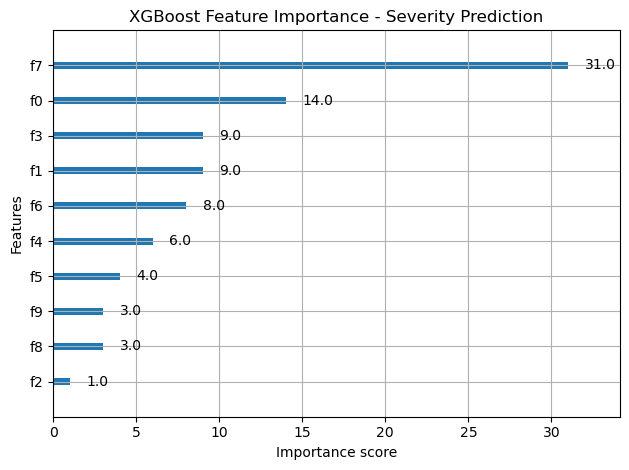

In [66]:
import matplotlib.pyplot as plt
import xgboost as xgb

plt.figure(figsize=(8, 6))

xgb.plot_importance(
    xgb_severity,
    max_num_features=13
)

plt.title('XGBoost Feature Importance - Severity Prediction')
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
